In [1]:
import chaosode
from scipy.interpolate import CubicSpline
from scipy import integrate
import numpy as np
from matplotlib import pyplot as plt
import utils  

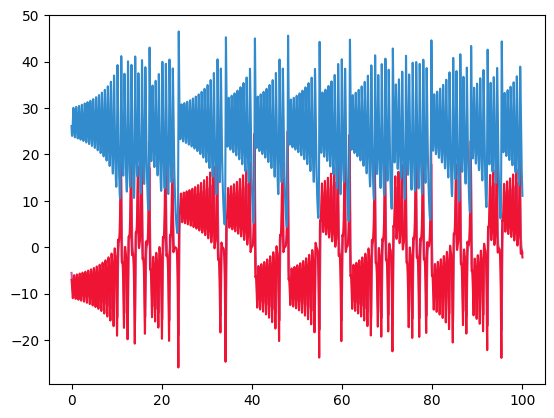

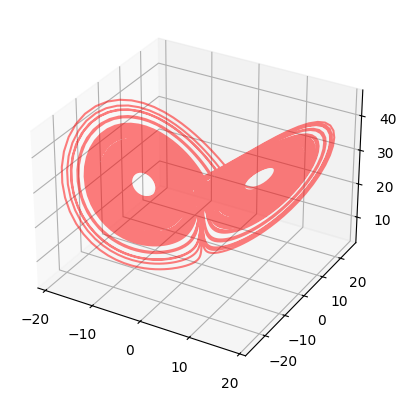

In [15]:
# Load Lorenz system data
t, U = chaosode.orbit("lorenz", duration=100)
colors = chaosode.plot2d(t, U)
_ = chaosode.plot3d(U, color="red")

# Interpolate data
u = CubicSpline(t, U) 
U_train = u(t[:9000])  # Observational data for training

#Create the true observation with multivariate normal random noise
def u0(t):
    return u(t) + np.random.multivariate_normal([0,0,0], 0*1e-7*np.eye(3), 1)

In [16]:
# Parameters
n = 50  # Number of reservoir nodes
gamma = 5  # Reservoir relaxation rate
sigma = 0.14  # Input scaling
mean_degree = 1
density = mean_degree / n
alpha = 1e-6  # Regularization parameter for training
nudging_strength = 0.0001  # Strength of the nudging term

In [17]:
# Directed Erdos-Renyi adjacency matrix
A = (np.random.rand(n, n) < density).astype(float)
# Fixed random matrix for input coupling
W_in = np.random.rand(n, 3) - 0.5

In [18]:
def drdt(r, t):
    return gamma * (-r + np.tanh(A @ r + sigma * W_in @ u(t)))

In [19]:
# Initial reservoir state
r0 = np.random.rand(n)

In [20]:
# Solve the reservoir dynamics during the training phase
states = integrate.odeint(drdt, r0, t[:9000])

In [21]:
# Training step: project training data onto reservoir states
W_out = U_train.T @ states @ np.linalg.inv(states.T @ states + alpha * np.eye(states.shape[1]))

In [22]:
# Prediction ODE IVP definition nudging during the prediction phase
def trained_drdt(r, t):
    r = r.reshape((-1,1))
    return (gamma * (-r + np.tanh(A @ r + sigma * W_in @ (W_out @ r + nudging_strength * (u0(t).T - W_out @ r))))).flatten()

# Initial state for prediction
r0_pred = states[-1, :]  # Use the final training state

In [23]:
# Solve for prediction phase
pred_states = integrate.odeint(trained_drdt, r0_pred, t[9000:])

# Map reservoir states onto the dynamical system space
U_pred = W_out @ pred_states.T

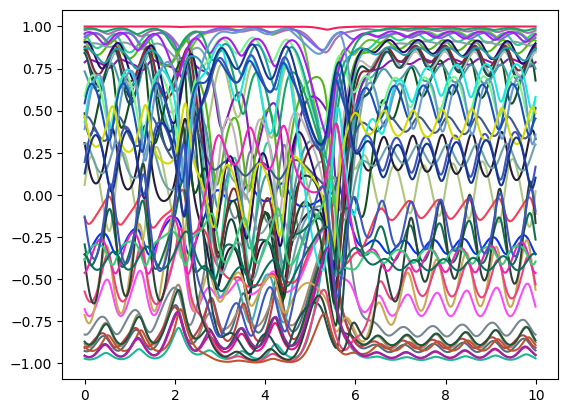

In [24]:
# Plot predictions
chaosode.plot2d(t[:1000], pred_states[:1000])
plt.show()

In [25]:
# Calculate Valid Prediction Time (VPT)
test_t = t[9000:]
vpt = utils.vpt_time(test_t, U_pred.T, u(test_t), vpt_tol=10)

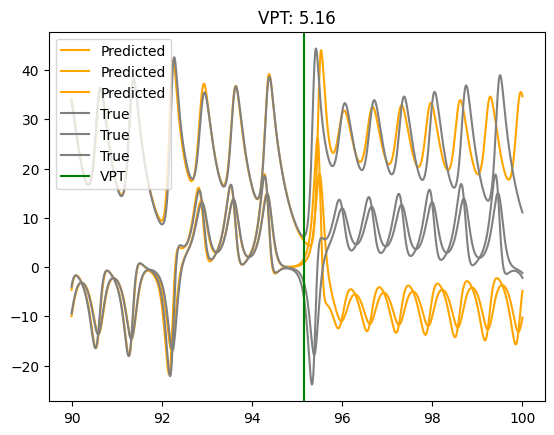

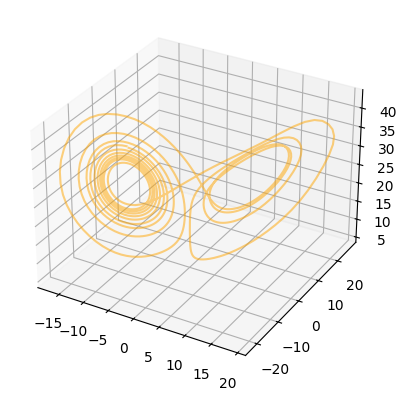

In [26]:
plt.title(f"VPT: {round(vpt,4)}")
plt.plot(test_t, U_pred.T, c="orange", label="Predicted")
plt.plot(test_t, u(test_t), c="gray", label="True")
plt.axvline(x=90 + vpt, color='green', label='VPT')
plt.legend()
plt.show()

_ = chaosode.plot3d(U_pred.T, color="orange")